Load libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pystan

Load the synthetic data we generated previously

In [2]:
dat = np.loadtxt('../data/data_npz_synthetic.csv', delimiter=',')

tobs = dat[:,0]
obs  = dat[:,[1,2,3]]

In the code below we introduce a new `generated quantities` block in order to make predictions for new time points.
Here we will solve the ODE much like before, but instead of having Stan return the solution at the observed time points, we ask Stan to return solutions at new time points of our choosing.
To do so, we need to pass Stan two more quantities in the `data` block: the number of predictions we are asking for, denoted `npred` and the specific time `tpred`.

In [3]:
stan_code_pred = '''
functions {                 
   real[] npz(real   t,     // time
              real[] x,     // state
              real[] theta, // parameters
              real[] x_r,   // fixed real data (empty)
              int[]  x_i) { // fixed integer data (empty)
   
    /*
    guide to theta:
    theta[1]:  vmax         maximum growth rate in Michaelis Menten formulation
    theta[2]:  nuthalfsat   nutrient half saturation in Michaelis Menten formulation
    theta[3]:  graz         zooplankton grazing rate
    theta[4]:  mort_p       phytoplankton mortality rate
    theta[5]:  mort_z       zooplankton mortality rate
    theta[6]:  irr          light amplitude
    */

    real n = fmax(0.0, x[1]); // this ensures our variables never go negative
    real p = fmax(0.0, x[2]);
    real z = fmax(0.0, x[3]);

    real light = 1.0 + 0.5*(theta[6]*sin(pi()*((t-81.25)/182.5))-theta[6]); // light limitation factor
    real growth = theta[1]*n/(theta[2]+n) * light * p;                      // phytoplankton growth term
    real grazing = theta[3]*p*z;                                            // zooplankton consumption term
    real ploss = theta[4]*p;                                                // phytoplankton mortality term
    real zloss = theta[5]*z*z;                                              // zooplankton mortality term
    
    return {-growth+ploss+zloss,  // rate of change for n
            growth-grazing-ploss, // rate of change for p
            grazing-zloss};       // rate of change for z
  }
}
data {
    int<lower=0> nobs;               // number of timesteps with observations
    real tobs[nobs];                 // obs times
    int<lower=0> nobsvar;            // number of observed variables
    int<lower=0> iobsvar[nobsvar];   // index of observed variable (N=0, P=1, Z=2)
    real<lower=0> obs[nobs,3];       // observed variable at measurement times
    int<lower=0> npred;              // number of points where we want predictions
    real tpred[npred];               // time points where we want predictions
}
parameters {
    real<lower=0> vmax;
    real<lower=0> nuthalfsat;
    real<lower=0> graz;
    real<lower=0> mort_p;
    real<lower=0> mort_z;
    real<lower=0,upper=1> irr;
    real<lower=0> x0[3];            // initial conditions
    real<lower=0> sigma[nobsvar];   // observation error (one for each observed variable)
}
transformed parameters {
    real x[nobs, 3];
    { 
        /* The curly braces here are creating a local variable scope.
        Variables declared inside the curly braces, like theta, cannot be used outside 
        the curly braces, they are also not included in the Stan output.
        Stan already outputs posterior samples for the model parameters, so additional 
        output for theta is not useful. Output for x is desired and x is also used in 
        the model block, so it needs to be declared outside the curly braces.
        */
        real theta[6] = {vmax,nuthalfsat,graz,mort_p,mort_z,irr};
        x = integrate_ode_rk45(npz, x0, 0, tobs, theta,
                               rep_array(0.0, 0), rep_array(0, 0),
                               1e-5, 1e-4, 1e4);
    }
}
model {
    vmax       ~ normal(0.1, 0.1);    // prior on vmax
    nuthalfsat ~ uniform(0.0, 1.0);   // prior on nuthalfsat
    graz       ~ normal(0.01, 0.01);  // prior on graz
    mort_p     ~ normal(0.01, 0.01);  // prior on mort_p
    mort_z     ~ normal(0.01, 0.01);  // prior on mort_z
    irr        ~ uniform(0.0, 1.0);   // prior on irr
    x0[1:3]    ~ normal(0.1, 0.1);    // prior on all three initial conditions
    for (iobs in 1:nobs){
        obs[iobs,iobsvar] ~ normal(x[iobs,iobsvar], sigma);   // likelihood of the observations
    }
}
generated quantities{
    real x_pred[npred,3];
    {real theta[6] = {vmax,nuthalfsat,graz,mort_p,mort_z,irr};
    x_pred = integrate_ode_rk45(npz,x0,0,tpred,theta,rep_array(0.0,0),rep_array(0,0),1e-5,1e-4,1e4);
    }
}
'''

Set which variables we are using to estimate the parameters and initial conditions

In [4]:
iobsvar = np.array([0,1,2])

Below we define the times when we want to predict and count the number of predictions

In [5]:
tpred = np.linspace(1.0, 365*2, 365)
npred = len(tpred)

We add these additional pieces of information to our data object

In [6]:
# convert from Python's 0-based indexing to Stan's 1-based
data = {'nobs':len(tobs), 'tobs':tobs, 'nobsvar':len(iobsvar), 'iobsvar':iobsvar+1, 'obs':obs, 'tpred':tpred, 'npred':npred}

In [7]:
model = pystan.StanModel(model_code=stan_code_pred, model_name='NPZ', obfuscate_model_name=False)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL NPZ NOW.


In [8]:
mcmc = model.sampling(data=data, iter=2000, chains=4)
print('\n'.join(x for x in mcmc.__str__().split('\n') if 'x_pred' not in x))

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Inference for Stan model: NPZ.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
vmax            0.09  3.3e-4   0.01   0.07   0.08   0.09    0.1   0.12   1056    1.0
nuthalfsat      0.42  5.5e-3   0.16   0.19    0.3   0.39   0.51   0.78    805    1.0
graz            0.02  6.4e-5 2.4e-3   0.01   0.02   0.02   0.02   0.02   1444    1.0
mort_p          0.02  1.5e-4 4.7e-3   0.01   0.02   0.02   0.02   0.03   1047    1.0
mort_z          0.03  1.1e-4 3.9e-3   0.02   0.02   0.03   0.03   0.03   1284    1.0
irr             0.88  2.6e-3   0.08   0.71   0.83   0.89   0.95    1.0    969    1.0
x0[1]           0.63  5.2e-4   0.02   0.58   0.62   0.63   0.64   0.67   1624    1.0
x0[2]           0.14  2.6e-4   0.01   0.12   0.13   0.14   0.15   0.17   2414    1.0
x0[3]           0.21  4.2e-4   0.02   0.18    0.2   0.21   0.23   0.25   1891    1.0
s

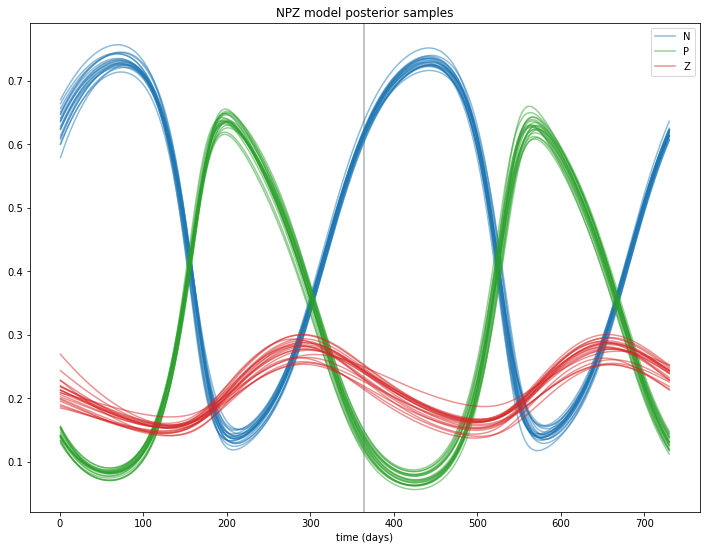

In [9]:
colors = ('#1f77b4','#2ca02c','#d62728') # colors for N, P, Z

fig,ax = plt.subplots(figsize=(12,9))
for i,name in enumerate(('N','P','Z')):
    label = name
    # plot only the first few samples
    for isample in range(20):
        ax.plot(tpred,mcmc['x_pred'][isample,:,i], color=colors[i], alpha=0.5, label=label)
        label = None
ax.axvline(365, color='0.7', zorder=0)
ax.set(title='NPZ model posterior samples', xlabel='time (days)')
ax.legend()
None

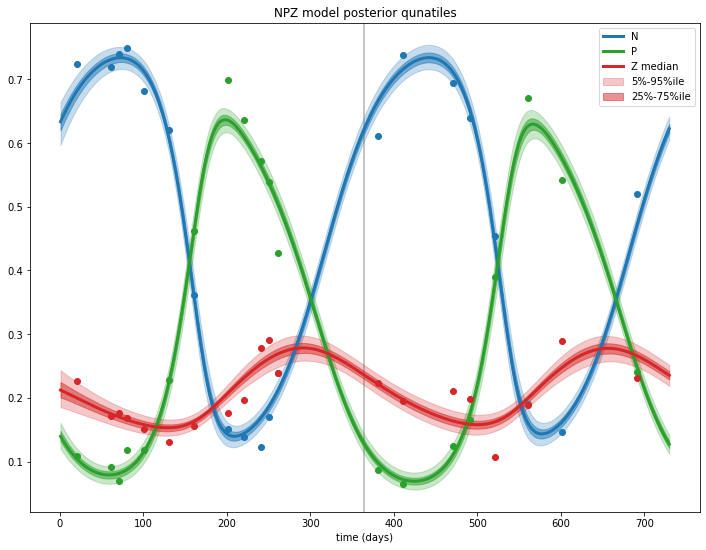

In [15]:
fig,ax = plt.subplots(figsize=(12,9))
for i,name in enumerate(('N','P','Z')):
    q = np.percentile(mcmc['x_pred'][:,:,i], q=(5,25,50,75,95), axis=0)
    label = None
    if i == 2:
        label = '5%-95%ile'
    ax.fill_between(tpred, q[0,:], q[-1,:], color=colors[i], alpha=0.25, label=label)
    if i == 2:
        label = '25%-75%ile'
    ax.fill_between(tpred, q[1,:], q[-2,:], color=colors[i], alpha=0.5, label=label)
    if i == 2:
        label = name + ' median'
    else:
        label = name
    ax.plot(tpred, q[2,:], color=colors[i], linewidth=3, label=label)
    ax.plot(tobs, obs[:,i], color=colors[i], marker='o', linestyle='none')
ax.axvline(365, color='0.7', zorder=0)
ax.set(title='NPZ model posterior qunatiles', xlabel='time (days)')
ax.legend()
None